### Imports of library

In [1]:
import cv2
import numpy as np
import time
import os 
import itertools
from sklearn.cluster import KMeans
import matplotlib.pyplot as  plt
import pickle as pkl
from IPython.display import clear_output as clr
import time
from sklearn.neural_network import MLPClassifier as MLP
from sklearn.model_selection import train_test_split as tts
from scipy import stats
from xgboost import XGBClassifier as XGC
from sklearn.ensemble import RandomForestClassifier as RFC

In [2]:
from sklearn.decomposition import PCA

In [3]:
def describeSURF(image):
    surf = cv2.xfeatures2d.SURF_create()
    surf.setHessianThreshold(400)
    kp, des = surf.detectAndCompute(image,None)
    return kp,des

def describeSIFT(image):
    sift = cv2.xfeatures2d.SIFT_create()
    kp, des = sift.detectAndCompute(image,None)
    return kp,des

def describeORB(image):
    orb=cv2.ORB_create()
    kp, des=orb.detectAndCompute(image,None)
    return kp,des

In [4]:
def getDescriptors(images,function):
    
    descriptors = []
    
    for im in images:
        
        kp,des = function(im)
        
        if des is not None:
            descriptors.append(des)
            
    descriptors = list(itertools.chain.from_iterable(descriptors))
    descriptors = np.asarray(descriptors)

    return descriptors

In [5]:
def get_kMeansModel(X, k):
    model = KMeans(n_clusters=k,init='k-means++',tol=0.0001,verbose=1).fit(X)
    return model

In [6]:
def get_VLAD(X,model):

    c_vals = model.predict(X)
    centers = model.cluster_centers_
    labels = model.labels_
    k = model.n_clusters
   
    m,d = X.shape
    V=np.zeros([k,d])
    
    for i in range(k):
        if np.sum(c_vals==i)>0:
            V[i]=np.sum(X[c_vals == i,:]-centers[i],axis=0)
            

    V = V.flatten()
    
    V = np.sign(V)*np.sqrt(np.abs(V))

    # L2 normalization
    V = V/np.sqrt(np.dot(V,V))
    
    
    vec = np.zeros(k)
    cv = np.unique(c_vals, return_counts =True)
    vec[cv[0]] = cv[1]
    
    vec = vec/np.sqrt(np.dot(vec,vec))
    vlad_vec = np.concatenate((V, vec))
    
    return vlad_vec

In [7]:
def getVLAD_Descriptors(images,function,k_model):
    descriptors = []

    
    
    for im in images:
        
        dess = []
        kp,des = function(im)
        if des is not None:
            dess.append(des)
        
        dess = list(itertools.chain.from_iterable(dess))
        dess = np.asarray(dess)
        
        description = get_VLAD(dess,k_model)
        
        descriptors.append(description)
    
    return descriptors

In [8]:
images = np.load("images.npy")
broad_label = np.load("broad_labels.npy")
comb_label = np.load("combined_labels.npy")

### SIFT Based Features

In [9]:
load_model  = True
if(load_model):
    X = np.load("X_SIFT.npy")
    with open("k_model_sift.pkl", "rb") as file:
        k_model_sift = pkl.load(file) 
else:
    X = getDescriptors(images, describeSIFT)
    k_model_sift = get_kMeansModel(X, 24)
    np.save("X_SIFT.npy", X)
    with open("k_model_sift.pkl", "wb") as file:
        pkl.dump(k_model_sift, file)

In [10]:
load_desc = load_model
if(not load_desc):
    desc = getVLAD_Descriptors(images, describeSIFT, k_model_sift)
    np.save("desc_sift.npy",desc)
else:
    desc = np.load("desc_sift.npy")

### SURF Based Features

In [11]:
load_model  = True
if(load_model):
    X = np.load("X_SURF.npy")
    with open("k_model_surf.pkl", "rb") as file:
        k_model_surf = pkl.load(file) 
else:
    X = getDescriptors(images, describeSURF)
    k_model_surf = get_kMeansModel(X, 24)
    np.save("X_SURF.npy", X)
    with open("k_model_surf.pkl", "wb") as file:
        pkl.dump(k_model_surf, file)

In [12]:
load_desc = load_model
if(not load_desc):
    desc = getVLAD_Descriptors(images, describeSURF, k_model_surf)
    np.save("desc_surf.npy",desc)
else:
    desc = np.load("desc_surf.npy")

### ORB Based Features

In [13]:
load_model  = True
if(load_model):
    X = np.load("X_ORB.npy")
    with open("k_model_orb.pkl", "rb") as file:
        k_model_orb = pkl.load(file) 
else:
    X = getDescriptors(images, describeORB)
    k_model_orb = get_kMeansModel(X, 24)
    np.save("X_ORB.npy", X)
    with open("k_model_orb.pkl", "wb") as file:
        pkl.dump(k_model_orb, file)

In [14]:
load_desc = load_model
if(not load_desc):
    desc = getVLAD_Descriptors(images, describeORB, k_model_orb)
    np.save("desc_orb.npy",desc)
else:
    desc = np.load("desc_orb.npy")

### Combining all : Concatenated Classification

In [15]:
desc_sift = np.load("desc_sift.npy")

In [16]:
desc_surf = np.load("desc_surf.npy")

In [17]:
desc_orb= np.load("desc_orb.npy")

In [ ]:
with open("k_model_sift.pkl", "rb") as file:
    k_model_sift = pkl.load(file) 
with open("k_model_surf.pkl", "rb") as file:
    k_model_surf = pkl.load(file) 
with open("k_model_orb.pkl", "rb") as file:
    k_model_orb = pkl.load(file) 

In [24]:
desc_sift = getVLAD_Descriptors(images, describeSIFT, k_model_sift)
desc_surf = getVLAD_Descriptors(images, describeSURF, k_model_surf)
desc_orb  = getVLAD_Descriptors(images, describeORB,  k_model_orb)

In [19]:
desc_net = np.concatenate((desc_sift, desc_surf, desc_orb), axis = 1)

In [20]:
X_train_c, X_test_c, y_train_c, y_test_c = tts(desc_net, broad_label, test_size=0.25,stratify = broad_label, random_state=42)

In [21]:
c_model_c = MLP(hidden_layer_sizes =(1000), validation_fraction = 0.33, early_stopping = True)

In [22]:
c_model_c.fit(X_train_c, y_train_c)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=True, epsilon=1e-08,
       hidden_layer_sizes=1000, learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.33, verbose=False, warm_start=False)

In [23]:
c_model_c.score(X_test_c, y_test_c)

0.8498349834983498

In [55]:
def solve_query(img):
    img = cv2.resize(img, (300,300))
    w,h,c = img.shape
    q_desc_sift = getVLAD_Descriptors(img.reshape(1,w,h,c), describeSIFT, k_model_sift)
    q_desc_surf = getVLAD_Descriptors(img.reshape(1,w,h,c), describeSURF, k_model_surf)
    q_desc_orb = getVLAD_Descriptors(img.reshape(1,w,h,c), describeORB, k_model_orb)
    
    q_desc_net = np.concatenate((q_desc_sift,q_desc_surf,q_desc_orb), axis = 1)
    idx = c_model_c.predict(q_desc_net)
    classes = ['airplane', 'birds', 'cars', 'dogs', 'flowers']
    print("This is in class : ", classes[idx[0]])
    
    return idx

ValueError: shapes (1,5448) and (5453,1000) not aligned: 5448 (dim 1) != 5453 (dim 0)

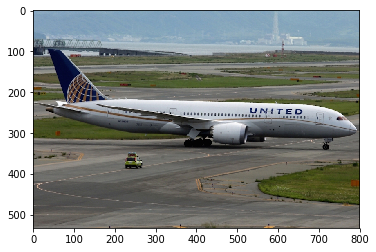

In [86]:
img = cv2.imread("../sample_test/05.jpg")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
solve_query(img)

In [58]:
preds = c_model_c.predict(desc_net)

In [63]:
desc_net.shape, preds.shape

((2423, 5448), (2423,))

In [105]:
p_model = PCA(n_components = 100)

In [106]:
X_tr_pca = p_model.fit_transform(desc_net)

In [107]:
from keras import utils as U

In [108]:
preds_cat = U.to_categorical(preds, num_classes = 5)

In [109]:
preds_cat.shape

(2423, 5)

In [110]:
new_feats = np.concatenate((X_tr_pca, preds_cat), axis = 1)

In [111]:
X_tr_pca.shape

(2423, 100)

In [112]:
X_train_c, X_test_c, y_train_c, y_test_c = tts(new_feats, comb_label, test_size=0.25,stratify = broad_label, random_state=42)

In [116]:
c_model_c = MLP(hidden_layer_sizes =(1000))

In [117]:
c_model_c.fit(X_train_c, y_train_c)

/home/abhikcr/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=1000, learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [119]:
c_model_c.score(X_test_c, y_test_c)

0.5957095709570958